In [1]:
import pandas as pd 
import transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
from tqdm import tqdm
import time 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from scipy import stats

print(torch.cuda.is_available())

/home/iris/Documents/Thesis/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


# Compute Loss and Perplexity for the example sentences 

Iris Luden 
May 2023 

This notebook investigates methods to obtain the cross-entropy loss, perplexity scores, and pseudo-perplexity scores for my data under investigation. 

The goal is to calculate the (1) cross entropy loss (2) perplexity scores, (3) pseudo-log likelihoods:
- For each target, context pair 
- For each definition
- For all 400 the annotated example sentences
- For all randomly sampled example sentences 


# Background 

#### A: Loss context/example sentences 

Calculate loss of the model on the context sentence of a target word

#### B: Perplexity over the entire sentences: 

    Given model $M$, and input sequence $Q$, we calculate the perplexity as follows: 
    $$PPL(Q) = exp^{H(M, Q)}$$ 
    where $H(M, Q)$ is the models cross-entropy for the input sequence Q.

#### C: Pseudo-perplexity or pseudo-log-likelihood, defined as: 

    $$ PLL(Q) := \sum^{|Q|}_{t=1} \log P_{M} (w_t|Q \setminus w_{t})$$ 
    
This is probability P_{M} is calculated differently depending on the model:
In the case of autoregressive models, it only takes into account the left-side context. 

The psuedo-perplexity for 1 sequence is equal to the PLL. One can also calculate the pseudo-perplexity over an entire corpus, by:

$$ PPPL(C) := exp (-\frac{1}{N} \sum_{Q \in C} PPL(Q) $$ 

Where $N$ denotes the number of sentences in C. 

#### D: masked target word prediction Loss 

The perplexity of target word $w$ in context sequence $Q$:
$$ PPL(Q, w_t) \approx exp^{H(M, Q, w_t)}$$

Where I define H(M, Q, w_t) as the loss of the task of predicting target word $w$ in the sequence $Q$ where $w$ is masked. 

# Description 

1. Scores for the example sentences
    - scores compute
    - analysis: correlations & visualizations
2. Scores for annotated example sentences 
    - scores compute
    - analysis: correlations & visualizations

# Model 

In [6]:
# initialize model 

model_id = "t5-base"
model = T5ForConditionalGeneration.from_pretrained(model_id)

# prepare the data
tokenizer = T5Tokenizer.from_pretrained(model_id)

/home/iris/Documents/Thesis/.env/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5.py:164: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


# Data 

In [21]:
# read complete data set 
df = pd.read_csv('All_DG_results.tsv', sep='\t')
display(df.head())

# retrieve categories 
stable = list(pd.read_csv('Targetwords/Stable_targets_20.tsv', sep='\t')['Word'])
changing = list(pd.read_csv('Targetwords/Changing_targets_20.tsv')['Word'])
emerging = list(pd.read_csv('Targetwords/Emerging_targets_20.tsv', sep='\t')['Word'])

def categorize(x, changing, emerging, stable):
    if x in changing:
        return 'changing'
    elif x in emerging:
        return 'emerging'
    elif x in stable:
        return 'stable'
    else: 
        return None 
    
# only inlcude the 20 target words used in the experiments 
df['Experiment set'] = df['Word'].map(lambda x: categorize(x, changing, emerging, stable_all))
display(df)
print(len(df))
df.dropna(inplace=True)
display(df)

,Word_id,Example,Prediction,Word,Corpus,Line,Category
0,airdrop%C2.1341010,aigo is an effort to design infrastructure dev...,the action of dropping something or someone by...,airdrop,C2,1341010,changing
1,airdrop%C2.1385892,katie ooh i got a picture of the mountain goat...,a by-product of an aeroplane,airdrop,C2,1385892,changing
2,airdrop%C2.1800549,user do you want a telegram airdrop bot ? mess...,an instance of delivering messages or informat...,airdrop,C2,1800549,changing
3,airdrop%C2.2190183,"cashapp 5,000 giveaway for one lucky person wh...",the action of dropping supplies or troops by p...,airdrop,C2,2190183,changing
4,airdrop%C2.2447061,user what a great project this project is very...,the action of dropping something or someone by...,airdrop,C2,2447061,changing
...,...,...,...,...,...,...,...
21207,zoom%C2.726451,i plan to offer my science behind cooking cour...,a means of transport by air,zoom,C2,726451,changing
21208,zoom%C2.796011,for phiballs who have purchased do n't forget ...,a state of rapid movement,zoom,C2,796011,changing
21209,zoom%C2.854768,the photo is n't explodingn but as you zoom ea...,alter or move ( an image ) so that it appears ...,zoom,C2,854768,changing
21210,zoom%C2.885895,i wanted a camera with a good zoom so i could ...,a camera lens that can be moved quickly to any...,zoom,C2,885895,changing


# 1. Cross-entropy loss and Perplexity 

Sources: 
https://huggingface.co/docs/transformers/model_doc/t5
https://huggingface.co/docs/transformers/perplexity

In [83]:
def nll(encoding, model):
    ''' Calculates the negalive-log-likelihood and perplexity 
    for the encoded sequence "encoding" and the model'''
    
    with torch.no_grad():
        outputs = model(encoding.input_ids, labels=encoding.input_ids)
        
    return (outputs.loss).item()

def nll_normalized(encoding, model):
    ''' Calculates the negalive-log-likelihood and perplexity 
    for the encoded sequence "encoding" and the model'''
    
    seq_length = encoding.input_ids.size(1)
    
    with torch.no_grad():
        outputs = model(encoding.input_ids, labels=encoding.input_ids)
        
    return ((outputs.loss)/seq_length).item()

def loss_in_context(sentence, target_word, tokenizer, model):
    ''' Calculates the perpllexity of the model of the target word in the sentence
    By calculating the loss when predicting the masked target word'''
    
    masked_encoding = tokenizer(sentence.replace(target_word, '<extra_id_0>'), return_tensors="pt")
    
    labels = ' '.join([f'<extra_id_{i}>' 
                       if (target_word not in sentence.split()[i])  else target_word 
                       for i in range(len(sentence.split()))])
    labels = tokenizer(labels, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model(masked_encoding.input_ids, labels=labels.input_ids)
        
    return outputs.loss.item()
    
def pseudo_perplexity2(sentence, model, tokenizer):
    ''' calculates the pseudo log likelihood for a sequence. 
    sums over the log probability of each token in the sequence, 
    conditioned on the context on both sides.
    NOTE: THE MASKING IS NOT GOING CORRECTLY. SHOULD BE REVISED'''
    all_nll = []
    
    splitted_sentence = sentence.split()
    
    for index in range(len(splitted_sentence)):
        
        target_word = splitted_sentence[index]
        
        masked_encoding = tokenizer(sentence.replace(target_word, '<extra_id_0>'), return_tensors="pt")
        
        labels = ' '.join([f'<extra_id_{i}>' 
                           if (target_word != sentence.split()[i])  else target_word 
                           for i in range(len(sentence.split()))])

        labels = tokenizer(labels, return_tensors="pt")

        with torch.no_grad():
            outputs = model(masked_encoding.input_ids, labels=labels.input_ids)
        
        all_nll.append(outputs.loss)
    
    return sum(all_nll).item()

def collect_perplexities(df, model, tokenizer):
    
    words_nll = []
    examples_nll = []
    
    for target_word, example in tqdm(df[['Word', 'Example']].values):
        
        words_nll.append(loss_in_context(example,  target_word, tokenizer, model))
        
        example_encoding = tokenizer(example, return_tensors="pt")
        examples_nll.append(nll(example_encoding, model))
        
    return words_nll, examples_nll

In [ ]:
# calculate perplexities 
words_nll, examples_nll = collect_perplexities(df, model, tokenizer)

# Create a df of results 

results_df = df.copy()
results_df['Words NLL'] = words_nll
results_df['Words PPL'] = results_df['Words NLL'].map(lambda x: np.exp(x))
results_df['Examples NLL'] = examples_nll
results_df['Examples PPL'] = results_df['Examples NLL'].map(lambda x: np.exp(x))

display(results_df.head())

# save to csv file
# results_df.to_csv('Perplexity_DG_results_first_20_target_words.tsv', sep='\t', index=False)

# Analysis

Of the 60 target words with 100 example sentences each. 

1. Compute correlations 
2. Create visualizations 

In [65]:
# read perplexities 
filename = 'Perplexity_DG_results_first_20_target_words.tsv'

ppl_df = pd.read_csv(filename, sep='\t')
display(ppl_df)

# remove the lines with example sentences of more than 100 words
ppl_df = ppl_df[ppl_df['Example'].map(lambda x: len(x.split()) < 100)]
print(len(ppl_df))

,Word_id,Example,Prediction,Word,Corpus,Line,Category,Words CE loss,Words PPL,Examples CE loss,Examples PPL
0,anchor%C1.1036715,that is n't how moths work goddammit they use ...,an objective which enables ships to land safel...,anchor,C1,1036715,changing,9.711153,1.650062e+04,0.875832,2.400871
1,anchor%C1.1055655,i would only go for this if touché was the anc...,providing stability in an otherwise uncertain ...,anchor,C1,1055655,changing,10.708086,4.471597e+04,1.143747,3.138507
2,anchor%C1.1100691,i 'd also really make sure he wants a kid and ...,support ( someone ) financially or emotionally,anchor,C1,1100691,changing,10.379551,3.219450e+04,0.598112,1.818682
3,anchor%C1.1100893,e-2 soldier pops to attention and salutes the ...,a horizontal piece of metal in the uniform to ...,anchor,C1,1100893,changing,10.514240,3.683634e+04,0.992434,2.697793
4,anchor%C1.1141159,take pill pay attention to the epiphanies and ...,support or hold in an anchored position,anchor,C1,1141159,changing,12.229303,2.047005e+05,0.549143,1.731768
...,...,...,...,...,...,...,...,...,...,...,...
8532,yacht%C2.811536,yacht trip with cpc leader and murray edwards ...,a light rowing boat used for short trips,yacht,C2,811536,changing,9.492001,1.325328e+04,0.468833,1.598129
8533,yacht%C2.815551,he 's the guy hired by one of the power ranger...,a medium-sized motor boat equipped for manoeuv...,yacht,C2,815551,changing,8.285960,3.967773e+03,0.065828,1.068043
8534,yacht%C2.832683,with the half i put in the bank wait 1 year pa...,a small sail on water used for recreation or r...,yacht,C2,832683,changing,10.201560,2.694519e+04,0.413767,1.512505
8535,yacht%C2.856841,maybe we 'll get lucky and dan snyder 's yacht...,a motor boat propelled by an internal combusti...,yacht,C2,856841,changing,23.422569,1.486937e+10,0.239851,1.271060


8524


#### 2.1 compute correlations 


In [66]:
# 2.1 correlation between corpus and perplexity
from scipy import stats


ppl_df['Corpus nr'] = ppl_df['Corpus'].map(lambda x: 1 if x =='C1' else 2)

corpus_correlation_scores = []

f1 = 'Corpus nr'

for f2 in ['Words CE loss', 'Words PPL', 'Examples CE loss', 'Examples PPL']:
    
    these_correlations = [f2]
    for method in ['points', 'kendall', 'spearman']:
        if method == 'spearman':
            results = stats.spearmanr(ppl_df[[f1, f2]].values)

        if method == 'points':
            results = stats.pointbiserialr(ppl_df[[f1, f2]].values[:,0],ppl_df[[f1, f2]].values[:,1])

        else: 
            results = stats.kendalltau(ppl_df[[f1, f2]].values[:,0],ppl_df[[f1, f2]].values[:,1])

        these_correlations += [results.statistic, results.pvalue]
    corpus_correlation_scores.append(these_correlations)

# create dataframe with correlations 
corpus_correlation_df = pd.DataFrame(corpus_correlation_scores, columns=['Score type', 'points', 'p', 'kendall', 'p','spearman', 'p'])
display(corpus_correlation_df.set_index(['Score type']))
display(ppl_df.groupby(['Category', 'Corpus']).mean('Words CE loss'))

,points,p,kendall,p,spearman,p
Score type,,,,,,
Words CE loss,0.032317,0.002845,-0.015100,0.087779,-0.015100,0.087779
Words PPL,-0.006123,0.571934,-0.015100,0.087779,-0.015100,0.087779
Examples CE loss,-0.029629,0.006225,-0.017735,0.044945,-0.017735,0.044945
Examples PPL,-0.029115,0.007184,-0.017735,0.044945,-0.017735,0.044945


Line  Words CE loss     Words PPL  Examples CE loss   
Category Corpus                                                                
changing C1      1.689326e+06      10.693895  8.535774e+09          0.694849  \
         C2      2.010911e+06      11.396333  1.093287e+09          0.700203   
emerging C2      2.224564e+06      10.822984  3.514030e+09          0.688372   
stable   C1      1.706054e+06      11.339040  2.176434e+09          0.756592   
         C2      1.811043e+06      11.688278  5.197969e+09          0.733756   

                 Examples PPL  Corpus nr  
Category Corpus                           
changing C1          2.176702        1.0  
         C2          2.190994        2.0  
emerging C2          2.183888        2.0  
stable   C1          2.399445        1.0  
         C2          2.303312        2.0

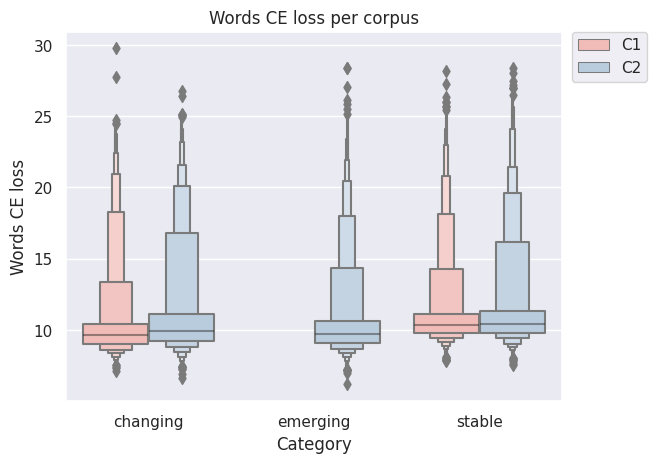

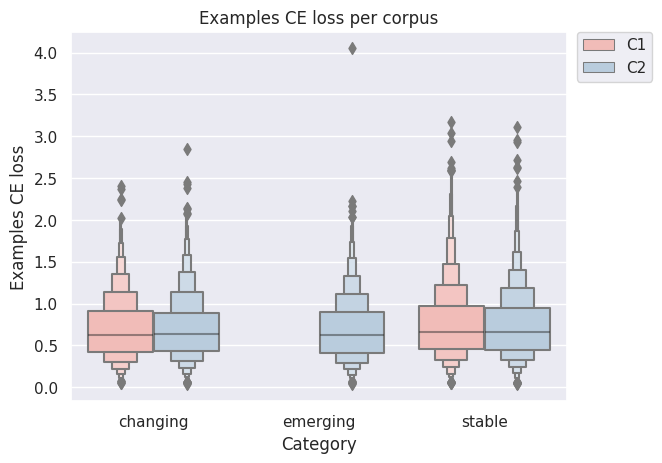

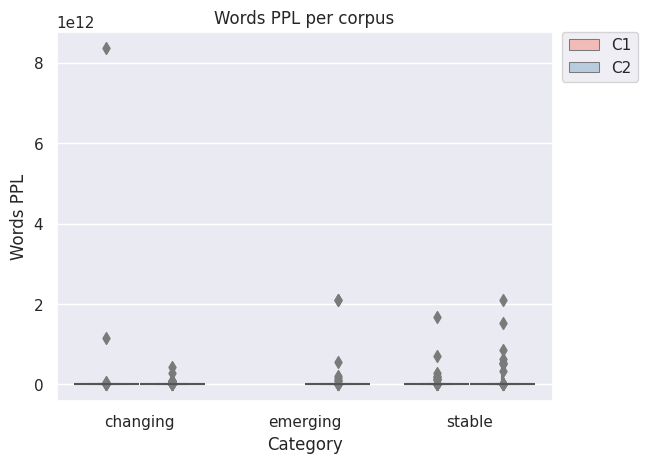

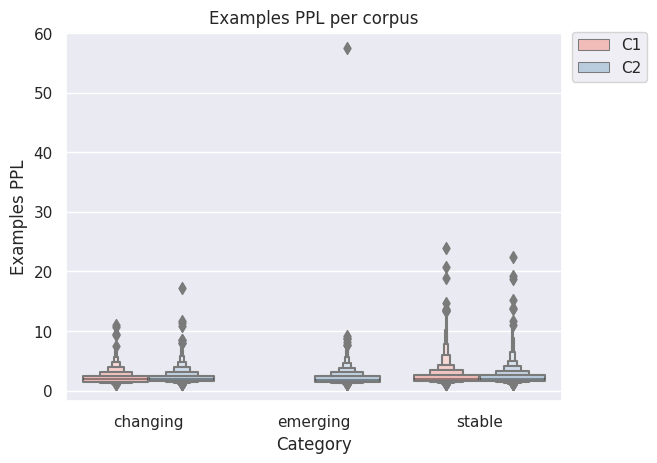

In [19]:
# 2.2 Visualize corpus and perplexities 

columns = ['Words CE loss', 'Examples CE loss', ]

# boxplot
sns.set(style="darkgrid")
for c in columns:
    sns.boxenplot(data=ppl_df, x='Category', y=c, hue='Corpus', palette="Pastel1")
    
    #place legend outside top right corner of plot
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.title(f'{c} per corpus')
    plt.savefig(f'Thesis_DG_results/plots/First_20_Corpora_{c}.png', bbox_inches='tight')
    plt.show()
    
# boxplot
columns = ['Words PPL', 'Examples PPL']
sns.set(style="darkgrid")
for c in columns:
    sns.boxenplot(data=ppl_df, x='Category', y=c, hue='Corpus', palette="Pastel1")
    #place legend outside top right corner of plot
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.title(f'{c} per corpus')
    plt.savefig(f'Thesis_DG_results/plots/First_20_Corpora_{c}.png',  bbox_inches='tight')
    plt.show()

3076
3817
Excluding emerging


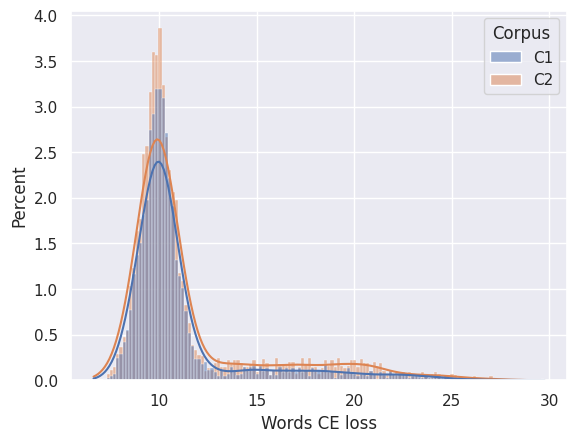

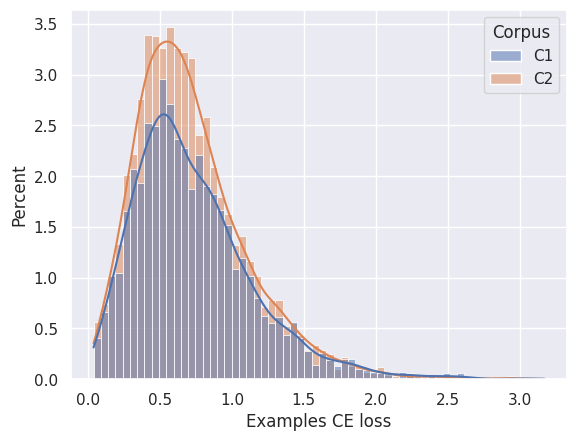

Including emerging


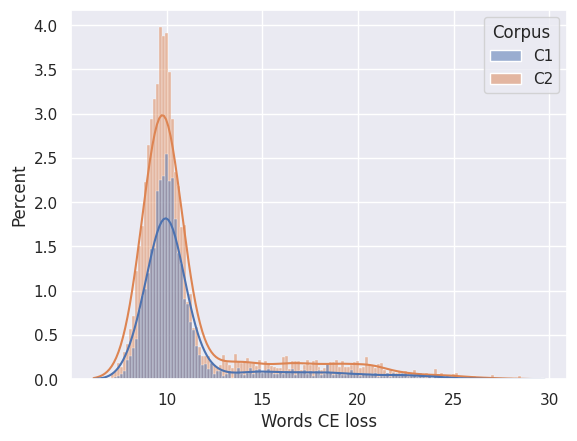

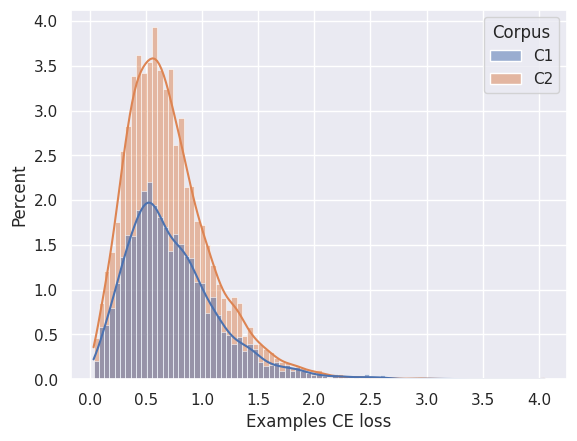

Not looking at corpus


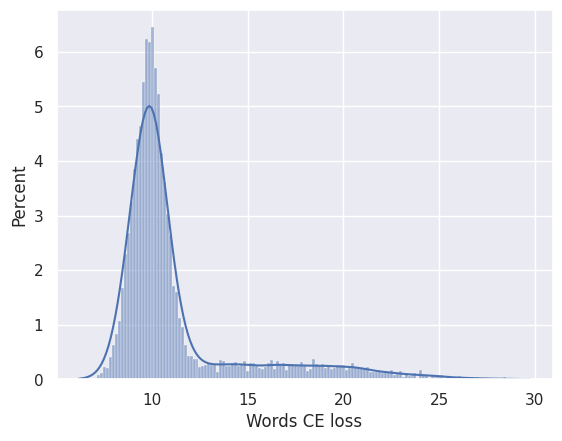

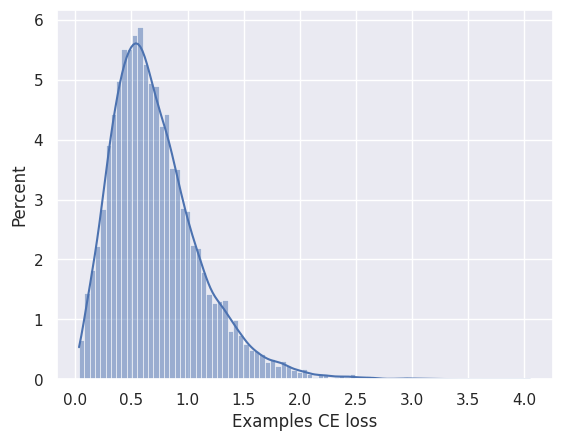

C1


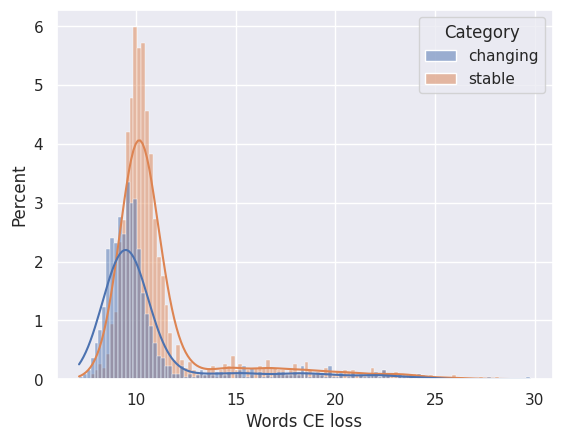

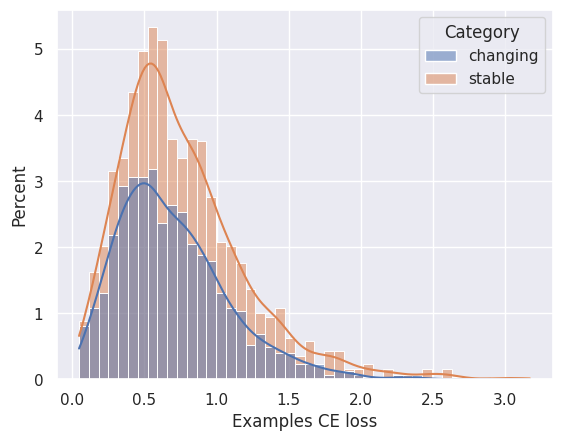

C2


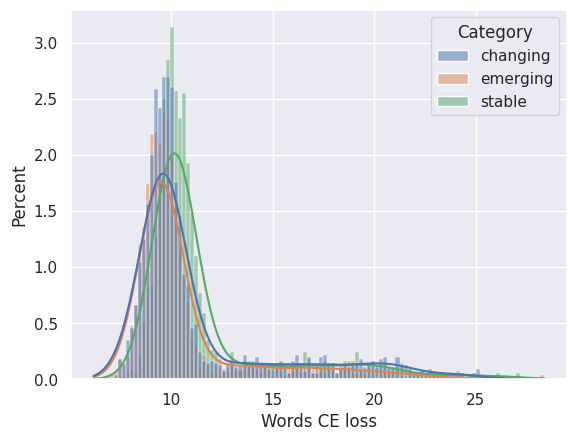

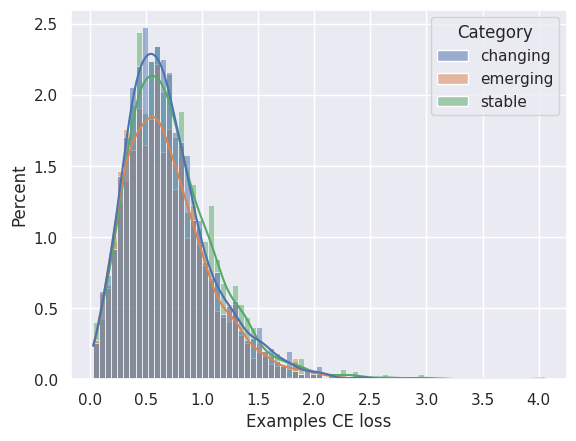

In [21]:
# 2.2 Visualize corpus and perplexities 
# distributions plots 

stat = 'percent'
print(sum(ppl_df['Corpus'] == 'C1'))
print(sum((ppl_df['Corpus'] == 'C2') & (ppl_df['Category'] != 'emerging')))


print("Excluding emerging")
sns.histplot(data=ppl_df[ppl_df['Category'] != 'emerging'], x='Words CE loss', kde=True, hue='Corpus', stat=stat)
plt.show()

sns.histplot(data=ppl_df[ppl_df['Category'] != 'emerging'], x='Examples CE loss', kde=True, hue='Corpus', stat=stat)
plt.show()

print("Including emerging")
sns.histplot(data=ppl_df, x='Words CE loss', kde=True, hue='Corpus', stat=stat)
plt.show()

sns.histplot(data=ppl_df, x='Examples CE loss', kde=True, hue='Corpus', stat=stat)
plt.show()

print("Not looking at corpus")
sns.histplot(data=ppl_df, x='Words CE loss', kde=True,stat=stat)
plt.show()

sns.histplot(data=ppl_df, x='Examples CE loss', kde=True,  stat=stat)
plt.show()



print("C1")
# distributions plots 
sns.histplot(data=ppl_df[ppl_df['Corpus'] == 'C1'], x='Words CE loss', kde=True, hue='Category', stat=stat)
plt.show()
# distributions plots 
sns.histplot(data=ppl_df[ppl_df['Corpus'] == 'C1'], x='Examples CE loss', kde=True, hue='Category', stat=stat)
plt.show()

print("C2")
sns.histplot(data=ppl_df[ppl_df['Corpus'] =='C2'], x='Words CE loss', kde=True, hue='Category', stat=stat)
plt.show()

sns.histplot(data=ppl_df[ppl_df['Corpus'] =='C2'], x='Examples CE loss', kde=True, hue='Category', stat=stat)
plt.show()
    

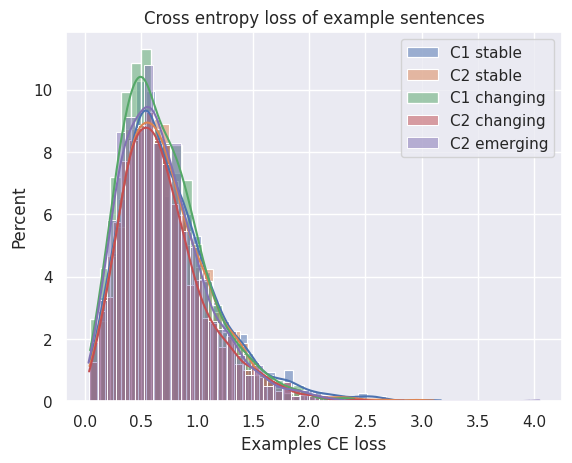

In [22]:
# 2.2 Visualize corpus and perplexities 

# visualise cross entropy loss 
for c2 in ['stable', 'changing']:
    for c1 in ['C1', 'C2']:    
        sns.histplot(data=ppl_df[(ppl_df['Corpus'] == c1) & (ppl_df['Category'] == c2)], 
                     x='Examples CE loss',
                     kde=True, label=f'{c1} {c2}', stat='percent')
        
sns.histplot(data=ppl_df[(ppl_df['Corpus'] == 'C2') & (ppl_df['Category'] == 'emerging')],
             x='Examples CE loss', 
             kde=True, label=f'C2 emerging', stat='percent')

plt.title('Cross entropy loss of example sentences')
plt.legend()
plt.savefig('Cross_entropy_example_sentences_all_20.png')
plt.show()



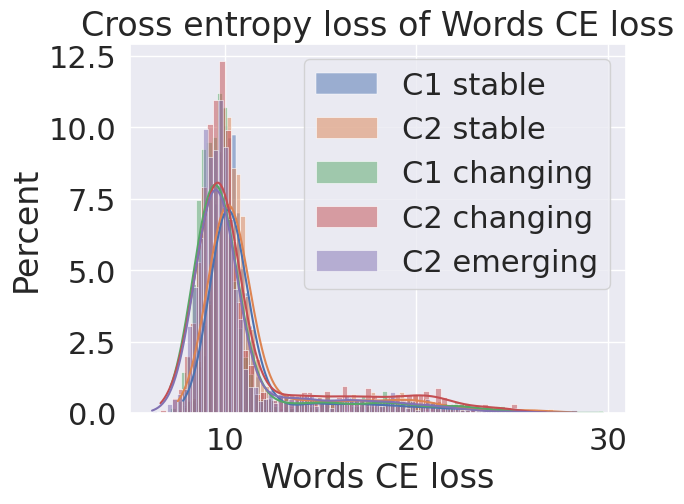

In [45]:
# Cross entropy loss of target word  

for c2 in ['stable', 'changing']:
    for c1 in ['C1', 'C2']:    
        sns.histplot(data=ppl_df[(ppl_df['Corpus'] == c1) & (ppl_df['Category'] == c2)], 
                     x='Words CE loss',
                     kde=True, label=f'{c1} {c2}', stat='percent')
        
sns.histplot(data=ppl_df[(ppl_df['Corpus'] == 'C2') & (ppl_df['Category'] == 'emerging')],
             x='Words CE loss', 
             kde=True, label=f'C2 emerging', stat='percent')

plt.title('Cross entropy loss of Words CE loss')
plt.legend()
# plt.savefig('Cross_entropy_example_sentences_all_20.png')
plt.show()


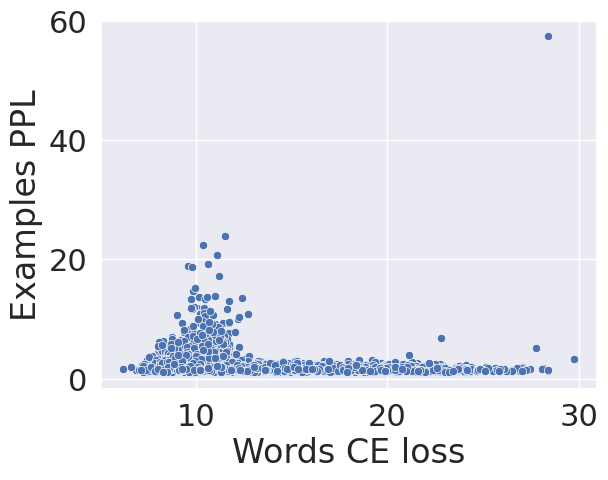

Word_id                                         manifesting%C1.649452
Example             whisper guy is probably dating his crazy ex ag...
Prediction          behaviour that is intended to impress or attra...
Word                                                      manifesting
Corpus                                                             C1
Line                                                           649452
Category                                                     changing
Words CE loss                                               10.238709
Words PPL                                                27965.012375
Examples CE loss                                             0.656222
Examples PPL                                                 1.927496
Name: 3894, dtype: object
Word_id                                              femboy%C2.689739
Example             i 'm a sissy femboy who is incredibly horny an...
Prediction                                        a promiscuous 

In [49]:
sns.scatterplot(data=ppl_df, x='Words CE loss', y='Examples PPL')
plt.show()

''' There is one outlier'''

print(ppl_df.iloc[ppl_df['Words CE loss'].idxmax()])
print(ppl_df.iloc[ppl_df['Examples PPL'].idxmax()])

# 2. Perplexity scores for the Annotated sentences 

In [ ]:
# read data
df_annotations = pd.read_csv('Annotations.tsv', sep='\t')
df_annotations

In [ ]:
# calculate the perplexity of the sequences
start = time.time()

# initiate lists 
words_nll =  []
examples_nll = []

for target_word, example, definition in tqdm(df_annotations[['Word', 'Example', 'Prediction']].values): 

    ### loss of target word in example sentence 
    words_nll.append(loss_in_context(example, target_word, tokenizer, model))
    
    ### calculate values for example sentences
    example_encoding = tokenizer(example, return_tensors="pt")
    examples_nll.append(nll(example_encoding, model))
    
end = time.time()
print("This took", end-start)

# write results 
import numpy as np
results_df = df_annotations[['Word_id', 'Example', 'Prediction', 'Corpus', 'Category', 
                             'Boolean majority', 'Averaged judgements', 'Kaya', 'Hanna', 'Laura']]

# add everything to data frame
results_df['Words NLL'] = words_nll
results_df['Words PPL'] = results_df['Words NLL'].map(lambda x: np.exp(x))

results_df['Examples NLL'] = examples_nll
results_df['Examples PPL'] = results_df['Examples NLL'].map(lambda x: np.exp(x))

display(results_df.head(6))


# now do pseudo perplexity
pseudo_examples = []

for target_word, example, definition in tqdm(df_annotations[['Word', 'Example', 'Prediction']].values): 

    ### loss of target word in example sentence 
    pseudo_examples.append(pseudo_perplexity2(example, model, tokenizer))

results_df['PLL Examples'] = pseudo_examples
results_df.to_csv('Perplexity_Annotations.tsv', sep='\t', index=False)

# Analysis of the perplexity scores Annotations 

In [72]:
file = 'Perplexity_Annotations.tsv' 
ppl_df = pd.read_csv(file, sep='\t')
ppl_df.head()

,Word_id,Example,Prediction,Corpus,Category,Boolean majority,Averaged judgements,Kaya,Hanna,Laura,Words CE loss,Words PPL,Examples CE loss,Examples PPL,Examples PLL,Summed judgements,Consensus vote
0,look%C1.1035374,in heroes and generals there you have limited ...,expect something to happen or be the case,C1,stable,1,1,2,2,3,9.670842,1.584869e+04,0.648296,1.912279,262.262573,7,1
1,look%C1.1116016,same thing i suggest for other agi lk is to lo...,orient oneself in order to find something,C1,stable,1,1,2,3,2,23.103514,1.080758e+10,0.591255,1.806254,1167.158569,7,1
2,look%C2.2838548,user user deftechpat juliadavisnews looks like...,have the appearance of being,C2,stable,1,1,3,3,3,9.618739,1.504407e+04,0.206372,1.229210,203.420319,9,1
3,look%C2.2035418,being thick is a trend that 's gon na die down...,behave in a specified way,C2,stable,0,0,0,0,0,8.928285,7.542317e+03,0.480664,1.617148,263.500793,0,0
4,look%C1.736364,i know there are a few setting sprays on sepho...,investigate ; study,C1,stable,1,1,3,2,2,10.097219,2.427542e+04,0.751478,2.120132,187.857056,7,1


In [73]:
pseudo_perplexities = []

print()
for c1 in ['C1', 'C2']:
    subdf = ppl_df[(ppl_df['Corpus'] == c1 )]
    N = sum(subdf['Example'].map(lambda x: len(x.split())))
    ppls = subdf['Examples PLL']
    PPPL = np.exp(-sum(ppls)/N)

    pseudo_perplexities.append([ c1, '-', PPPL])
    
print()
for c2 in ['stable', 'changing', 'emerging']:
    subdf = ppl_df[(ppl_df['Category'] == c2)]
    N = sum(subdf['Example'].map(lambda x: len(x.split())))
    ppls = subdf['Examples PLL']
    PPPL = np.exp(-sum(ppls)/N)

    pseudo_perplexities.append(['-', c2, PPPL])
    
# emerging 
for c1 in ['C1', 'C2']:
    for c2 in ['stable', 'changing']:
        subdf = ppl_df[(ppl_df['Corpus'] == c1 ) & (ppl_df['Category'] == c2)]
        N = sum(subdf['Example'].map(lambda x: len(x.split())))
        ppls = subdf['Examples PLL']
        PPPL = np.exp(-sum(ppls)/N)
        pseudo_perplexities.append([c1, c2, PPPL])

# now for emerging 
c1, c2 = 'C2', 'emerging'
subdf = ppl_df[(ppl_df['Corpus'] == c1 ) & (ppl_df['Category'] == c2)]
N = sum(subdf['Example'].map(lambda x: len(x.split())))
ppls = subdf['Examples PLL']
PPPL = np.exp(-sum(ppls)/N)
pseudo_perplexities.append([c1, c2, PPPL])

pseudo_df = pd.DataFrame(pseudo_perplexities, columns=['Corpus', 'Category', 'Pseudo-perplexity'])
pseudo_df

,Corpus,Category,Pseudo-perplexity
0,C1,-,0.000007
1,C2,-,0.000007
2,-,stable,0.000005
3,-,changing,0.000010
4,-,emerging,0.000010
5,C1,stable,0.000006
6,C1,changing,0.000008
7,C2,stable,0.000004
8,C2,changing,0.000012
9,C2,emerging,0.000010


# 2a. Visualization 

Annotation correctness V.S. perplexity 


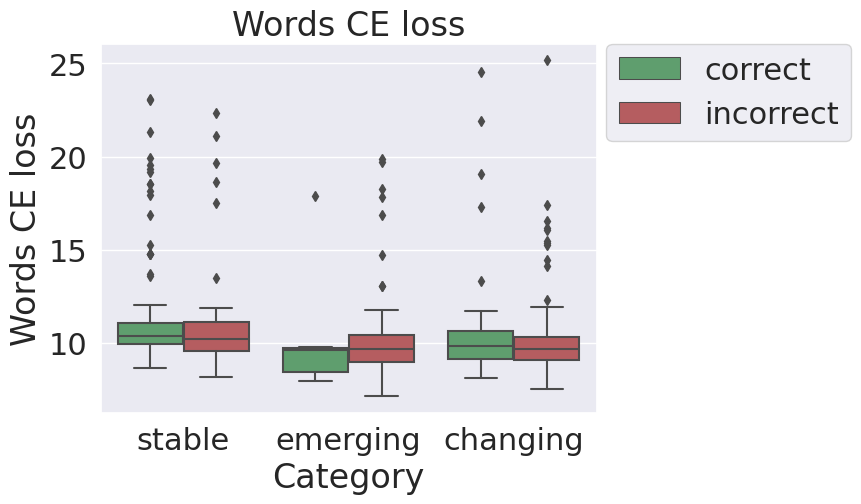

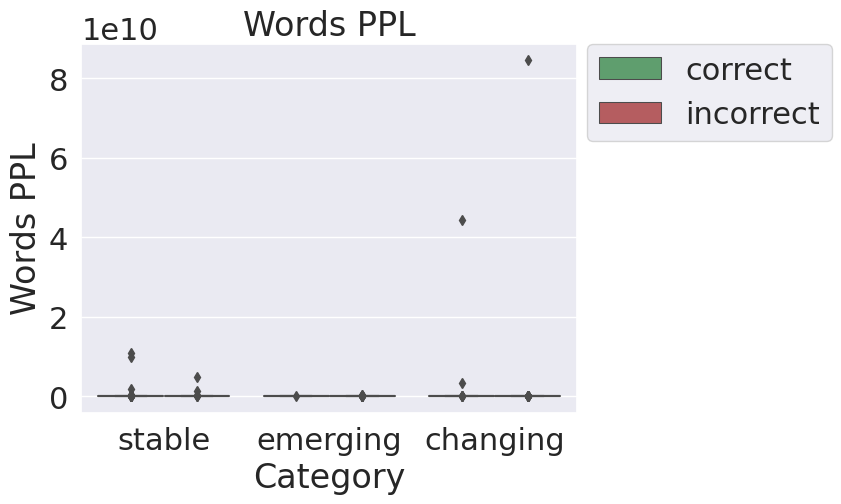

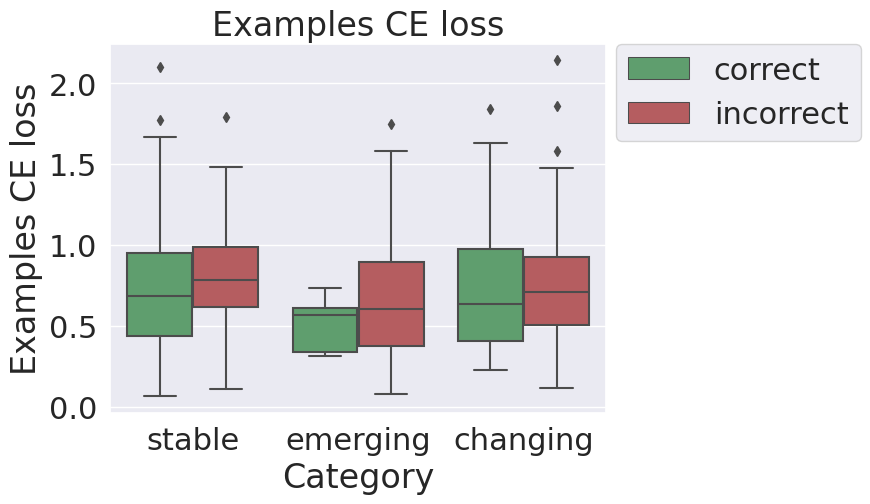

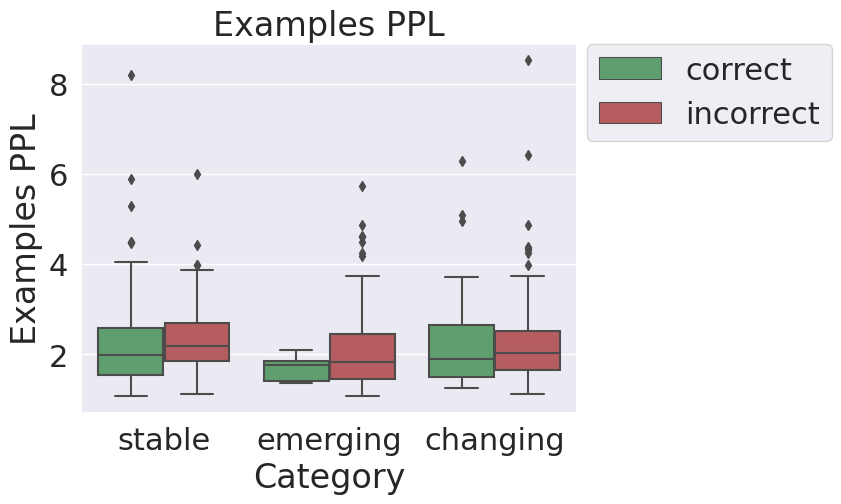

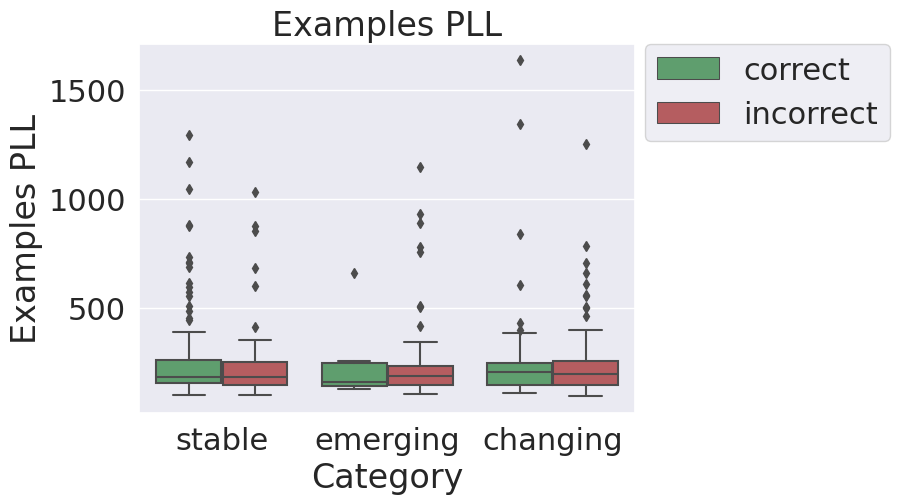

In [56]:
ppl_df['Label'] = ppl_df['Boolean majority'].map(lambda x: 'incorrect' if x == 0 else 'correct')
palette_dict = {'correct':'g', 'incorrect':'r'}

# boolean majority vote
sns.set(font_scale=2)
columns = ['Words CE loss', 'Words PPL', 'Examples CE loss', 'Examples PPL', 'Examples PLL']
for c in columns:
    sns.boxplot(data=ppl_df, x='Category', y=c, hue='Label' , palette=palette_dict)
    
    #place legend outside top right corner of plot
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.title(f'{c}')
    plt.savefig(f'Thesis_DG_results/plots/Annotators_Boolean_majority_{c}.png', bbox_inches='tight')
    plt.show()
    

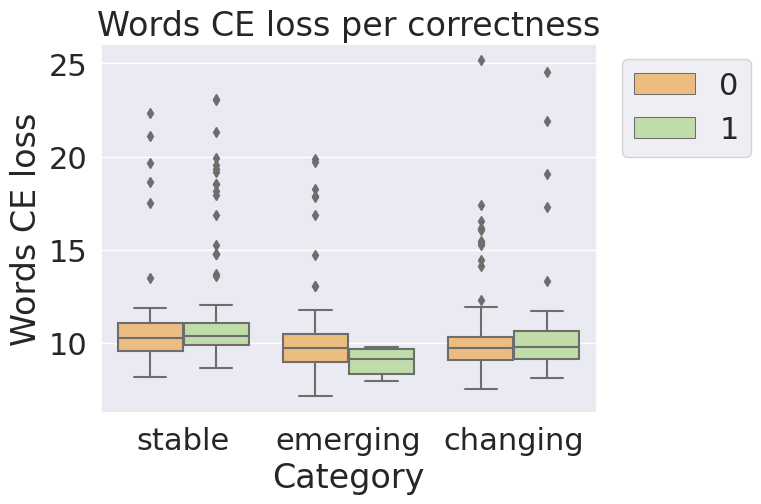

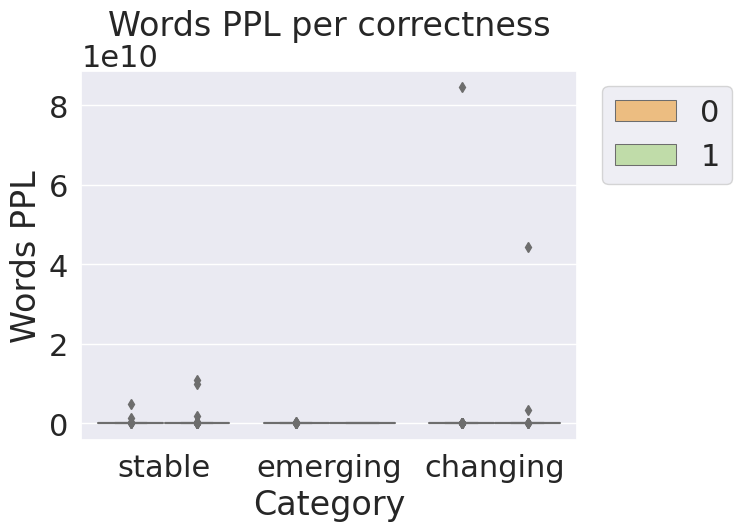

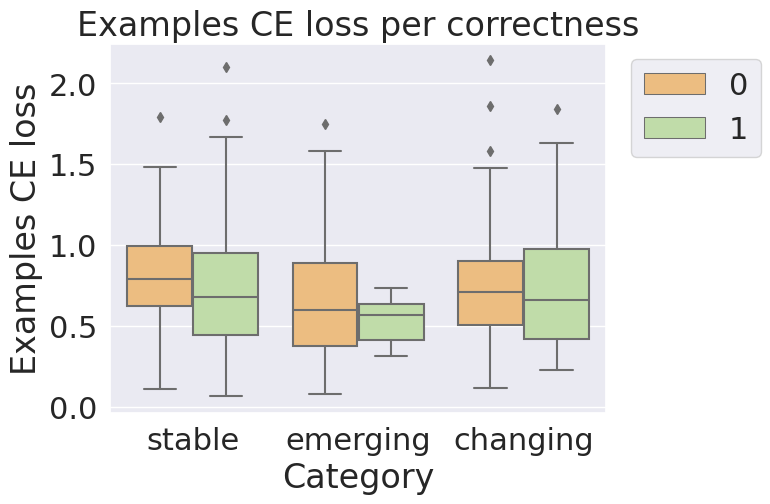

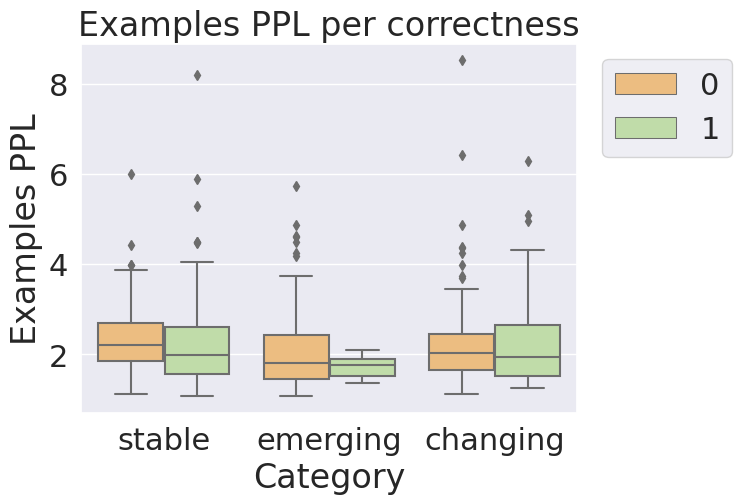

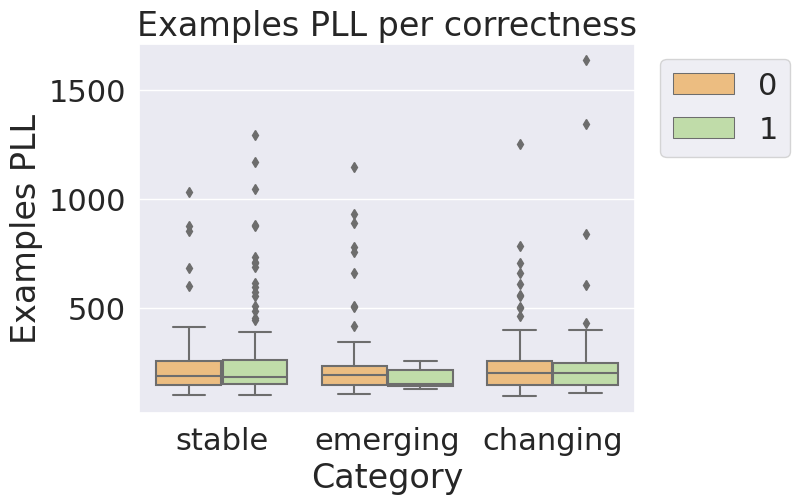

In [57]:
# average vote
for c in columns:
    sns.boxplot(data=ppl_df, x='Category', y=c, hue='Averaged judgements', palette="Spectral")
    
    #place legend outside top right corner of plot
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.title(f'{c} per correctness' )
    
    plt.savefig(f'Thesis_DG_results/plots/Annotators_Averaged_judgements_{c}.png',  bbox_inches='tight')
    plt.show()

<Axes: xlabel='Words CE loss', ylabel='Examples PPL'>

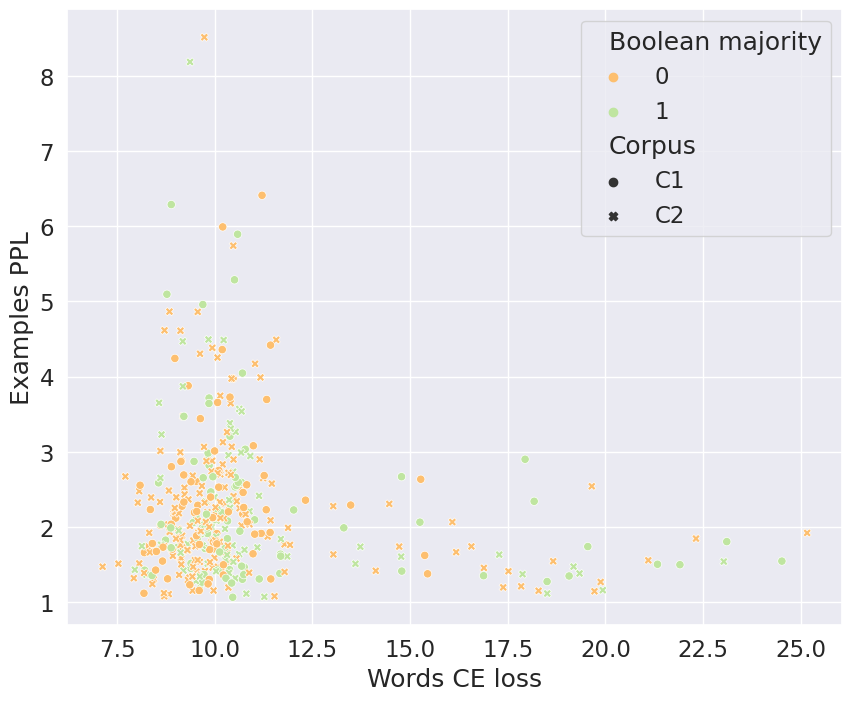

In [224]:
# scatterplots 
sns.set(font_scale=1.5)

sns.scatterplot(data=ppl_df, x='Words CE loss', y='Examples PPL', hue='Boolean majority', style='Corpus', palette="Spectral")
plt.show()
sns.scatterplot(data=ppl_df, x='Words CE loss', y='Examples PLL', hue='Boolean majority', style='Corpus', palette="Spectral")
plt.show()

sns.scatterplot(data=ppl_df, x='Examples PPL', y='Examples PLL', hue='Boolean majority', style='Corpus', palette="Spectral")
plt.show()

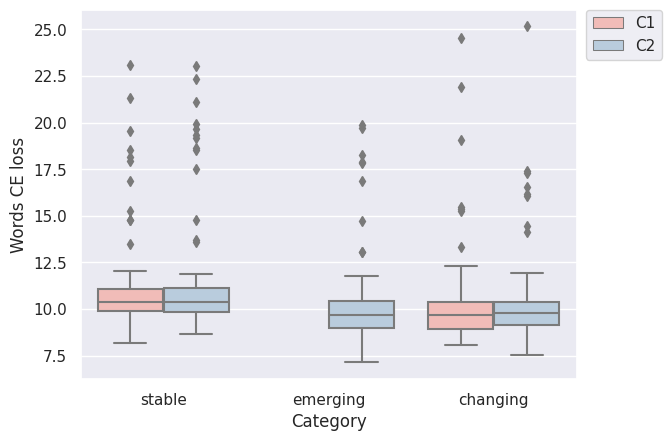

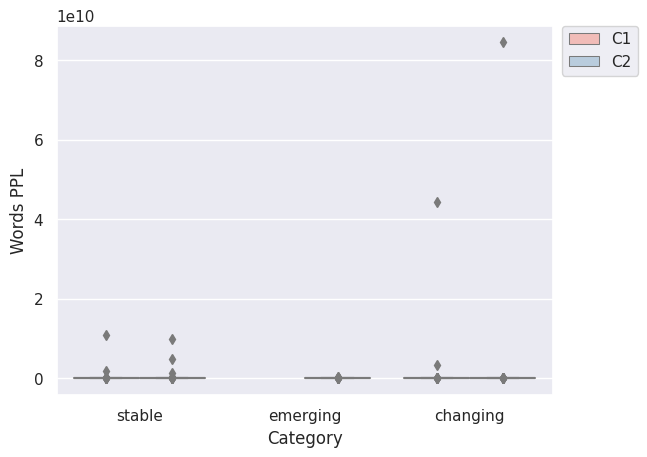

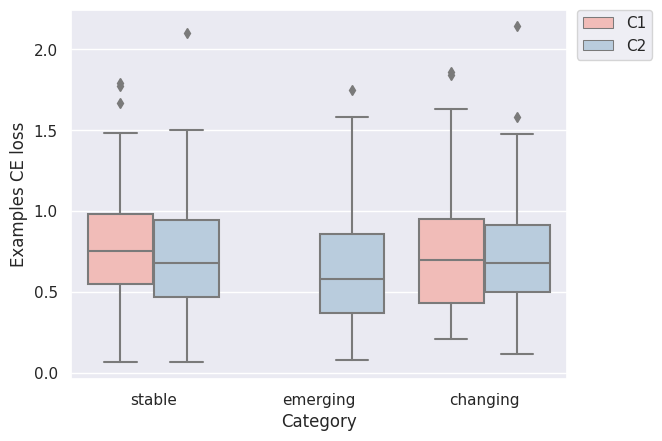

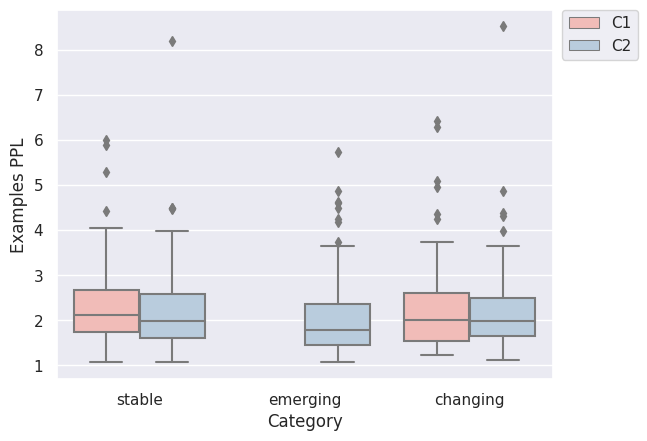

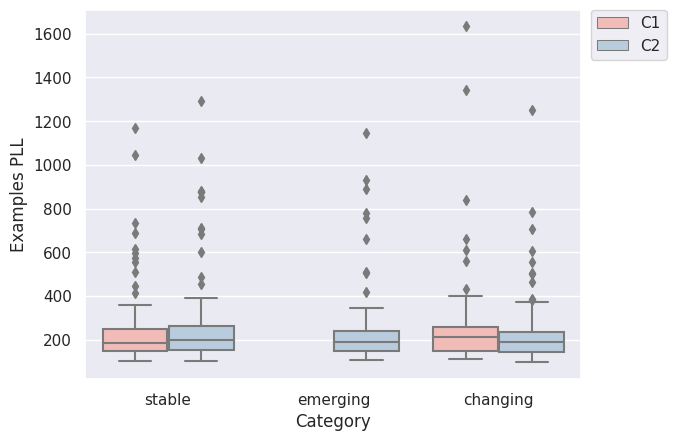

In [63]:
# Visualize ppl v.s. corpus of annotations 
columns = ['Words CE loss', 'Words PPL', 'Examples CE loss', 'Examples PPL', 'Examples PLL']

# boxplot
sns.set(style="darkgrid")
for c in columns:
    sns.boxplot(data=ppl_df, x='Category', y=c, hue='Corpus', palette="Pastel1")
    
    #place legend outside top right corner of plot
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.savefig(f'Thesis_DG_results/plots/Annotators_Corpora_{c}.png')
    plt.show()

In [ ]:
# Correlation correctness vs. perplexity of annotations 

# pearson correlation
# p-values https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance

correctness_correlation_scores = []
for method in ['points', 'kendall', 'spearman']:
    print(method)
    for f1 in ['Boolean majority', 'Averaged judgements', 'Summed judgements']:

        for f2 in ['Words CE loss', 'Words PPL', 'Examples CE loss', 'Examples PPL', 'Examples PLL']:
            
            if method == 'spearman':
                results = stats.spearmanr(ppl_df[[f1, f2]].values)

            if method == 'points':
                results = stats.pointbiserialr(ppl_df[[f1, f2]].values[:,0],ppl_df[[f1, f2]].values[:,1])

            else: 
                results = stats.kendalltau(ppl_df[[f1, f2]].values[:,0],ppl_df[[f1, f2]].values[:,1])
                correlation = ppl_df[[f1, f2]].corr(method=method)[f1][1]
                
            correctness_correlation_scores.append([method, f1, f2, results.statistic, results.pvalue])

correctness_correlation_df = pd.DataFrame(correctness_correlation_scores, columns=['Method', 'Judgement aggregation', 'Score type', 'correlation', 'p'])
display(correctness_correlation_df.set_index(['Method', 'Judgement aggregation']))


# Some more analysis

Which words+examples have the highest loss/perplexity?

<Figure size 1500x1500 with 0 Axes>

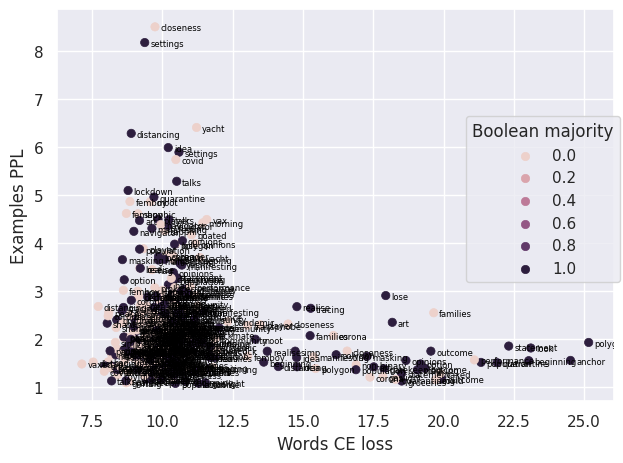

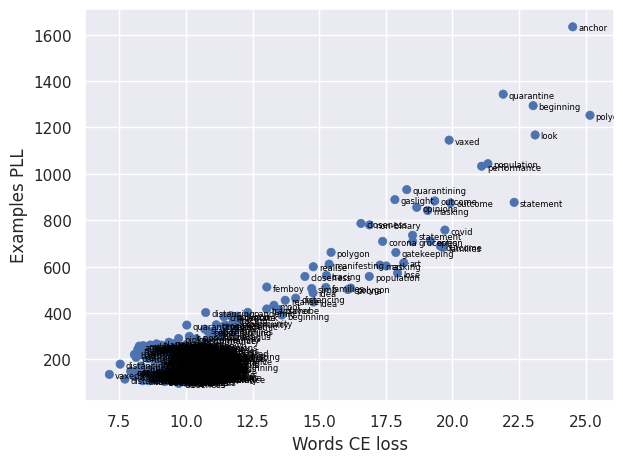

In [194]:
#### Visualizations
import seaborn.objects as so

ppl_df['Word'] = ppl_df['Word_id'].map(lambda x: x.split("%")[0])
sns.set_theme()
sns.despine()
sns.set_context('paper')
# sns.set(rc={'figure.figsize':(15, 15)})

ax = so.Plot(data=ppl_df, x='Words CE loss', y='Examples PPL', text='Word', color='Boolean majority').add(so.Dot()).add(so.Text(color='black', halign='left',fontsize=6))
ax.limit(x=(0 , 1.5), y=(0 ,0.8)) # this does not work
ax.show()

ax = so.Plot(data=ppl_df, x='Words CE loss', y='Examples PLL', text='Word').add(so.Dot()).add(so.Text(color='black', halign='left',fontsize=6))
ax.limit(x=(0 , 1.5), y=(0 ,0.8))
ax.show()


In [287]:
# See what the highest scores are 
print(ppl_df['Words CE loss'].idxmax())
print(ppl_df['Examples PPL'].idxmax())
print(ppl_df['Examples PLL'].idxmax())

226
393
152


In [58]:

for index in [226, 393, 152]: 
    print(ppl_df.iloc[index]['Word_id'])
    print(ppl_df.iloc[index]['Example'])
    print(ppl_df.iloc[index]['Boolean majority'])
    print(ppl_df.iloc[index]['Prediction'])
    print()

polygon%C2.2414326
user user respawn polygon if you not have a skilled player in the titan then the titan would be dead so fast xd you need to be good i 'm both ways or you will be eaten alive the longer they play the better they will be like in every game out there
0
a three-dimensional recreation in which players use two or more lines to move around one another

closeness%C2.2594055
user closeness to yt supremacy is hella of a drug
0
the quality of being attentive or lenient

anchor%C1.437835
the other two consoles are less enticing to run alongside causal anchor on an all-exotic setup for the eternal though the 3-piece does reduce the cooldown on the console actives as the 2-piece set grants some hull strength and extra energy weapon damage the tactical system stabilizer is focused on weapon damage output and the chronotachyon capacitor involves both a taunt effect and bonuses to weapons .
1
a thing used to support or fasten something else

